# Lab Assignment Part-2
## Poojitha Venkatram, Shruti Badrinarayanan

In [ ]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
from sklearn.metrics import classification_report
import torch

## Loading the Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_path = '/content/drive/MyDrive/Micro_Organism'

In [ ]:
#! pip install opencv-python-headless

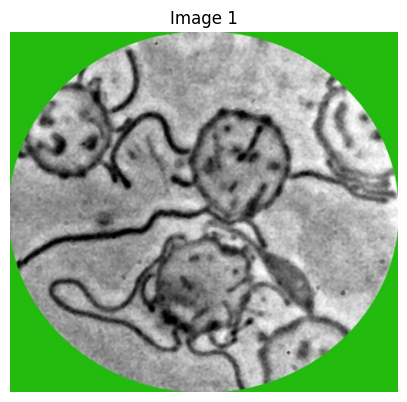

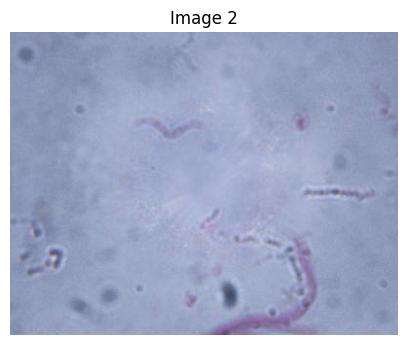

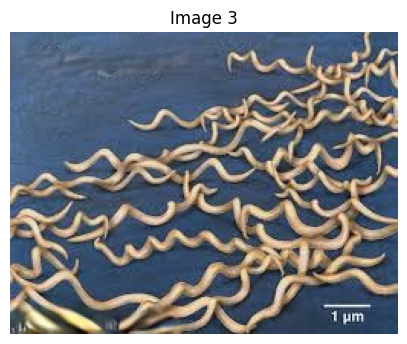

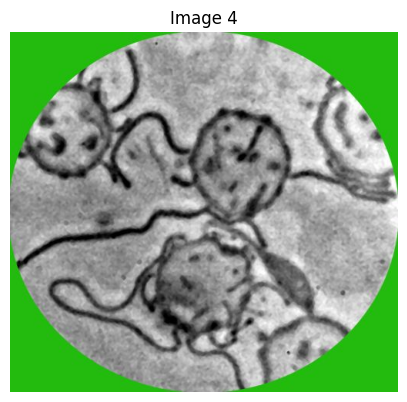

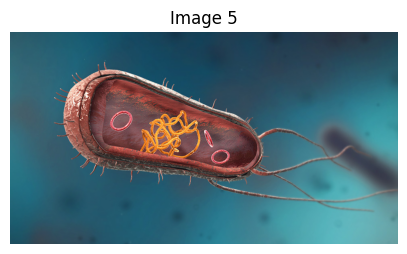

In [ ]:
import cv2
import os
import matplotlib.pyplot as plt

# Path to the dataset directory
dataset_path = '/content/drive/MyDrive/Micro_Organism'

# Function to load images
def load_images_from_folder(folder_path, num_images=5):
    images = []
    for dirname in os.listdir(folder_path):
        class_path = os.path.join(folder_path, dirname)
        for filename in os.listdir(class_path):
            if filename.endswith(".jpg") or filename.endswith(".png"):
                img_path = os.path.join(class_path, filename)
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                images.append(img)
                if len(images) >= num_images:
                    return images
    return images

# Loading a few images
images = load_images_from_folder(dataset_path, num_images=5)

# Displaying the images
for i, img in enumerate(images):
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.title(f"Image {i+1}")
    plt.axis('off')
    plt.show()

## Visualizing/Summarizing the data

In [ ]:
class_names = os.listdir(dataset_path)
print(class_names)
num_class = len(class_names)
image_files = [[os.path.join(dataset_path, class_name, x)
               for x in os.listdir(os.path.join(dataset_path, class_name))]
               for class_name in class_names]

['Spiral_bacteria', 'Euglena', 'Spherical_bacteria', 'Amoeba', 'Rod_bacteria', 'Paramecium', 'Yeast', 'Hydra']


In [ ]:
image_file_list = []
image_label_list = []
for i, class_name in enumerate(class_names):
    image_file_list.extend(image_files[i])
    image_label_list.extend([i] * len(image_files[i]))
num_total = len(image_label_list)

In [ ]:
image_width, image_height = Image.open(image_file_list[0]).size

print('Total image count:', num_total)
print("Image dimensions:", image_width, "x", image_height)
print("Label names:", class_names)
print("Label counts:", [len(image_files[i]) for i in range(num_class)])

Total image count: 789
Image dimensions: 504 x 468
Label names: ['Spiral_bacteria', 'Euglena', 'Spherical_bacteria', 'Amoeba', 'Rod_bacteria', 'Paramecium', 'Yeast', 'Hydra']
Label counts: [75, 168, 86, 72, 85, 152, 75, 76]


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    image_file_list, image_label_list, test_size=0.2, random_state=42, stratify=image_label_list
)

print("Training set size:", len(X_train))
print("Testing set size:", len(X_test))
print("Number of classes:", len(set(image_label_list)))

Training set size: 631
Testing set size: 158
Number of classes: 8


In [ ]:
from PIL import Image

# Loading the first image to get dimensions
image = Image.open(image_file_list[0])
image_width, image_height = image.size

print("Image dimensions:", image_width, "x", image_height)

Image dimensions: 504 x 468


In [ ]:
from collections import Counter

# Assuming image_label_list contains labels for each image
label_counts = Counter(image_label_list)

print("Number of images per class are as follows,")
for label, count in label_counts.items():
    print(f"Class {label}: {count} images")

Number of images per class are as follows,
Class 0: 75 images
Class 1: 168 images
Class 2: 86 images
Class 3: 72 images
Class 4: 85 images
Class 5: 152 images
Class 6: 75 images
Class 7: 76 images


In [ ]:
from collections import Counter
import plotly.express as px

label_counts = Counter(image_label_list)

# Calculating class distribution (counts) based on class_names order
class_dis = [label_counts.get(i, 0) for i in range(len(class_names))]

# Creating the pie plot
fig = px.pie(names=class_names, values=class_dis, title="Class Distribution")
fig.update_layout({'title':{'x':0.45}})
fig.show()

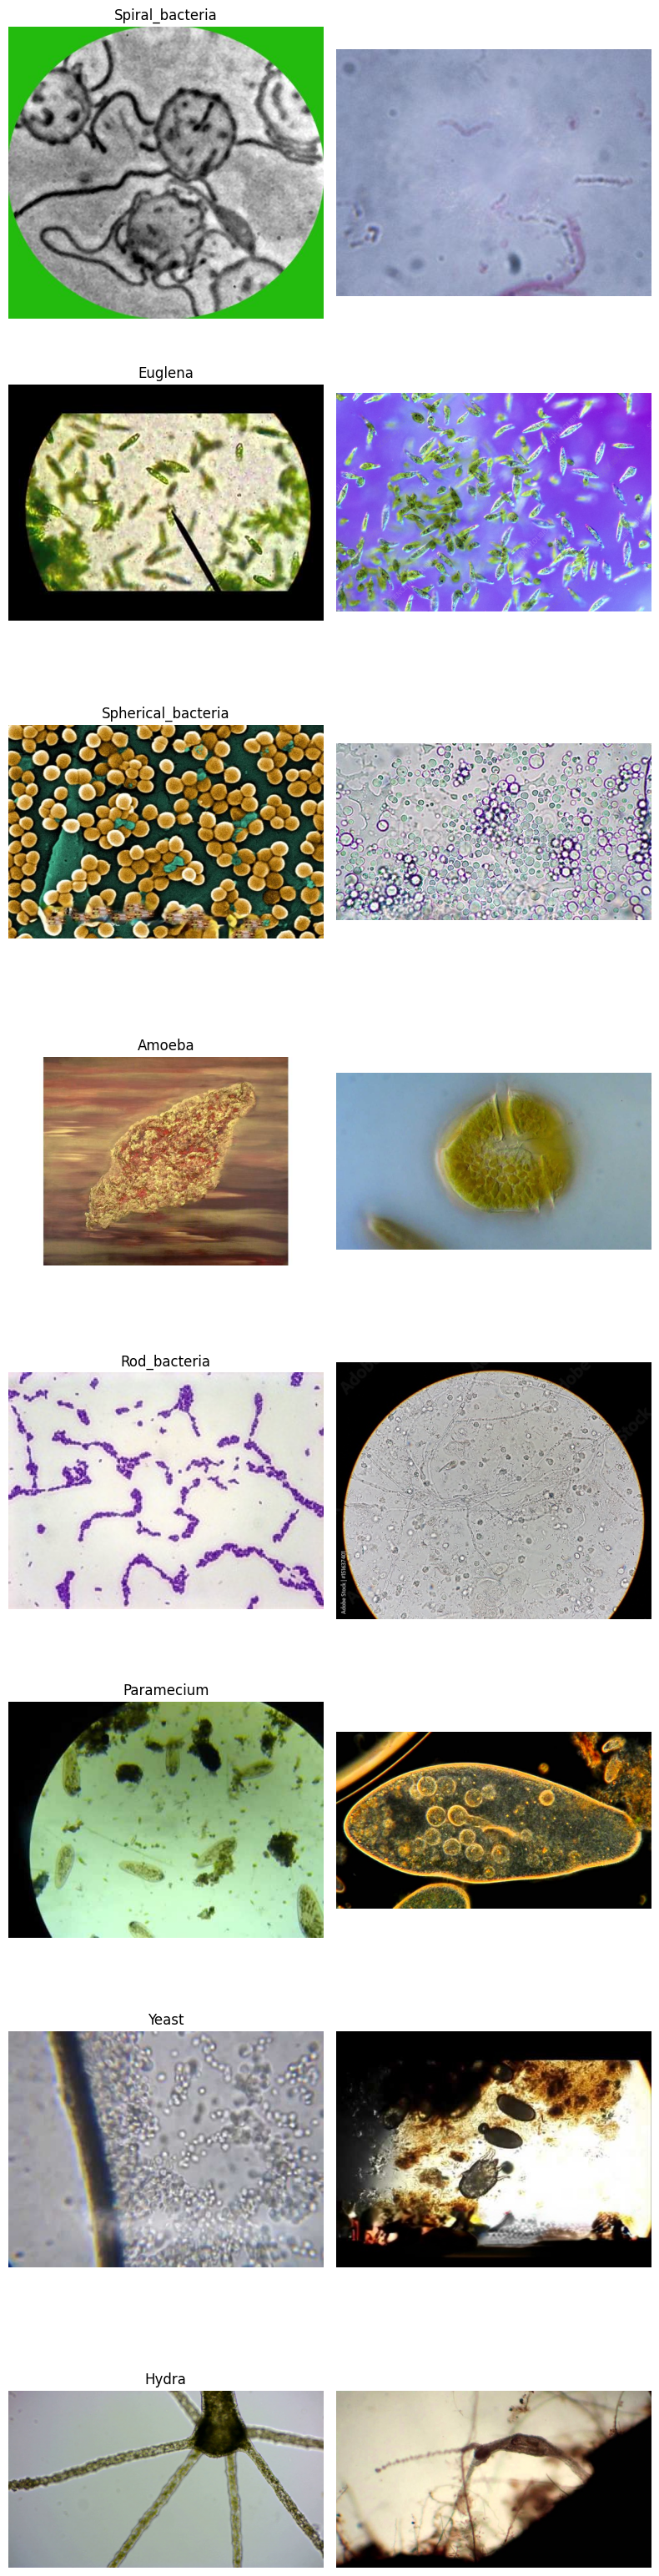

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

def display_images_by_class(image_file_list, image_label_list, class_names, num_images=2):
    # Mapping from class index to image file paths
    class_to_images = {}
    for image_path, label in zip(image_file_list, image_label_list):
        if label not in class_to_images:
            class_to_images[label] = []
        class_to_images[label].append(image_path)

    # Setting up the matplotlib figure and axes
    num_classes = len(class_names)
    fig, axes = plt.subplots(num_classes, num_images, figsize=(num_images * 4, num_classes * 4))

    # Looping through each class to display images
    for label, images in class_to_images.items():
        selected_images = images[:num_images]
        for idx, image_path in enumerate(selected_images):
            img = Image.open(image_path)
            if num_classes == 1:
                ax = axes[idx]
            else:
                ax = axes[label, idx]
            ax.imshow(img)
            ax.axis('off')
            if idx == 0:
                ax.set_title(class_names[label])

    plt.tight_layout()
    plt.show()

# Calling the function
display_images_by_class(image_file_list, image_label_list, class_names)

### Defining the Neural Network

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
import numpy as np
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

In [ ]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms

class CustomImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

## Defining Transformations

In [ ]:
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import torch

batch_size = 32
img_height = 224
img_width = 224
data_dir = '/content/drive/MyDrive/Micro_Organism'

# Define transformations
transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),  # Resize images to fit the model input
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize images
])

# Loading the dataset
dataset = datasets.ImageFolder(data_dir, transform=transform)

# Splitting the dataset into train, validation, and test sets
train_size = int(0.8 * len(dataset))
val_size = int(0.10 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Creating dataloaders for training, validation, and test sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self, num_classes=8):
        super(CustomCNN, self).__init__()

        self.conv_base = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),

            nn.Conv2d(64, 192, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        # The rest of the model architecture
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(192, 256)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.conv_base(x)
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = CustomCNN(num_classes=8)
print(model)

CustomCNN(
  (conv_base): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (global_avg_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc1): Linear(in_features=192, out_features=256, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=256, out_features=8, bias=True)
)


#### Without Dropout

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self, num_classes=8):
        super(CustomCNN, self).__init__()
        # Defining the layers
        self.conv_base = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),

            nn.Conv2d(64, 192, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(192, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.conv_base(x)
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.log_softmax(x)  # Applying log-softmax on the final output
        return x

model_no_dropout = CustomCNNNoDropout(num_classes=8)
print(model_no_dropout)

CustomCNNNoDropout(
  (conv_base): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (global_avg_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc1): Linear(in_features=192, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=8, bias=True)
)


In [ ]:
import torch.optim as optim

# Assuming model_no_dropout is defined as CustomCNN with log_softmax as the final layer
model = CustomCNN(num_classes=8).to(device)

# Defining the loss function and optimizer
criterion = nn.NLLLoss()  # Using Negative Log Likelihood Loss
optimizer = optim.Adagrad(model.parameters(), lr=0.001)  # Using Adagrad

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for images, labels in train_loader:  # Placeholder for your training data loader
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_preds += (predicted == labels).sum().item()
        total_preds += labels.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    train_acc = correct_preds / total_preds

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct_preds = 0
    total_preds = 0

    with torch.no_grad():
        for images, labels in val_loader:  # Placeholder for your validation data loader
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)

    val_loss /= len(val_loader.dataset)
    val_acc = correct_preds / total_preds

    print(f'Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

print('Finished Training')

Epoch 1/10 - Train loss: 2.0406, Train Acc: 0.2060, Val loss: 1.9964, Val Acc: 0.3077
Epoch 2/10 - Train loss: 1.9870, Train Acc: 0.2456, Val loss: 1.9449, Val Acc: 0.3205
Epoch 3/10 - Train loss: 1.9469, Train Acc: 0.2742, Val loss: 1.9132, Val Acc: 0.3718
Epoch 4/10 - Train loss: 1.9150, Train Acc: 0.2964, Val loss: 1.8854, Val Acc: 0.3333
Epoch 5/10 - Train loss: 1.8882, Train Acc: 0.3265, Val loss: 1.8708, Val Acc: 0.3205
Epoch 6/10 - Train loss: 1.8666, Train Acc: 0.3312, Val loss: 1.8748, Val Acc: 0.3205
Epoch 7/10 - Train loss: 1.8504, Train Acc: 0.3281, Val loss: 1.8565, Val Acc: 0.3590
Epoch 8/10 - Train loss: 1.8384, Train Acc: 0.3328, Val loss: 1.8567, Val Acc: 0.3333
Epoch 9/10 - Train loss: 1.8302, Train Acc: 0.3296, Val loss: 1.8560, Val Acc: 0.3462
Epoch 10/10 - Train loss: 1.8199, Train Acc: 0.3344, Val loss: 1.8507, Val Acc: 0.3718
Finished Training


### Using Different Activation Functions

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self, num_classes=8):
        super(CustomCNN, self).__init__()

        # Define LeakyReLU activation
        self.leaky_relu = nn.LeakyReLU(0.01)

        self.conv_base = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            self.leaky_relu,  # Using LeakyReLU instead of ReLU
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),

            nn.Conv2d(64, 192, kernel_size=3, stride=1, padding=1),
            self.leaky_relu,  # Using LeakyReLU instead of ReLU
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(192, 256)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.conv_base(x)
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.leaky_relu(self.fc1(x))  # Applying LeakyReLU here as well
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = CustomCNN(num_classes=8)
print(model)

CustomCNN(
  (leaky_relu): LeakyReLU(negative_slope=0.01)
  (conv_base): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.01)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (global_avg_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc1): Linear(in_features=192, out_features=256, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=256, out_features=8, bias=True)
)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score

model = CustomCNN(num_classes=8).to(device)

# Defining the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Using Cross-Entropy Loss
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)  # Using SGD with momentum

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    train_correct = 0
    train_total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == labels).sum().item()
        train_total += labels.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    train_acc = train_correct / train_total

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= len(val_loader.dataset)
    val_acc = val_correct / val_total

    print(f'Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

Epoch 1/10 - Train loss: 2.0693, Train Acc: 0.1616, Val loss: 2.0381, Val Acc: 0.2308
Epoch 2/10 - Train loss: 2.0331, Train Acc: 0.2139, Val loss: 1.9930, Val Acc: 0.2692
Epoch 3/10 - Train loss: 2.0148, Train Acc: 0.2171, Val loss: 1.9752, Val Acc: 0.2821
Epoch 4/10 - Train loss: 2.0079, Train Acc: 0.2076, Val loss: 1.9677, Val Acc: 0.2564
Epoch 5/10 - Train loss: 1.9991, Train Acc: 0.2060, Val loss: 1.9543, Val Acc: 0.2821
Epoch 6/10 - Train loss: 1.9831, Train Acc: 0.2425, Val loss: 1.9356, Val Acc: 0.2564
Epoch 7/10 - Train loss: 1.9566, Train Acc: 0.2345, Val loss: 1.9111, Val Acc: 0.2821
Epoch 8/10 - Train loss: 1.9250, Train Acc: 0.2647, Val loss: 1.8684, Val Acc: 0.2949
Epoch 9/10 - Train loss: 1.8852, Train Acc: 0.2964, Val loss: 1.8572, Val Acc: 0.3205
Epoch 10/10 - Train loss: 1.8754, Train Acc: 0.3059, Val loss: 1.8510, Val Acc: 0.3205


### L2 Regularization with weight decay

In [ ]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes=8):
        super(CustomCNN, self).__init__()
        self.conv_base = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.Conv2d(64, 192, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(192, 256)
        self.dropout = nn.Dropout(0.5)  # Adding Dropout with a 50% probability
        self.fc2 = nn.Linear(256, num_classes)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.conv_base(x)
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Applying Dropout
        x = self.fc2(x)
        x = self.log_softmax(x)
        return x

model = CustomCNN(num_classes=8)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Move the model to the configured device
model = model.to(device)

# Defining the loss function
criterion = nn.CrossEntropyLoss()

# Defining the optimizer with a specified weight decay for L2 regularization
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

num_epochs = 10  # Specify the number of epochs

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct_preds += (predicted == labels).sum().item()
        total_preds += labels.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    train_acc = correct_preds / total_preds

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct_preds = 0
    total_preds = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)

    val_loss /= len(val_loader.dataset)
    val_acc = correct_preds / total_preds

    print(f'Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

Epoch 1/10 - Train loss: 2.0380, Train Acc: 0.1933, Val loss: 1.9644, Val Acc: 0.2436
Epoch 2/10 - Train loss: 1.9834, Train Acc: 0.2298, Val loss: 1.8876, Val Acc: 0.3590
Epoch 3/10 - Train loss: 1.9030, Train Acc: 0.3106, Val loss: 1.8751, Val Acc: 0.2949
Epoch 4/10 - Train loss: 1.9051, Train Acc: 0.2837, Val loss: 1.8576, Val Acc: 0.3333
Epoch 5/10 - Train loss: 1.8918, Train Acc: 0.3011, Val loss: 1.8136, Val Acc: 0.3718
Epoch 6/10 - Train loss: 1.8322, Train Acc: 0.3106, Val loss: 1.7985, Val Acc: 0.3333
Epoch 7/10 - Train loss: 1.8423, Train Acc: 0.3170, Val loss: 1.8345, Val Acc: 0.3333
Epoch 8/10 - Train loss: 1.8043, Train Acc: 0.3217, Val loss: 1.8663, Val Acc: 0.3077
Epoch 9/10 - Train loss: 1.8584, Train Acc: 0.3138, Val loss: 1.8466, Val Acc: 0.3462
Epoch 10/10 - Train loss: 1.7886, Train Acc: 0.3423, Val loss: 1.8208, Val Acc: 0.3333


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

model = CustomCNN(num_classes).to(device)

# Defining the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 25

for epoch in range(num_epochs):
    model.train()  # Setting the model to training mode
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the parameter gradients

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_preds += (predicted == labels).sum().item()
        total_preds += labels.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    train_acc = correct_preds / total_preds

    # Validation phase
    model.eval()  # Setting the model to evaluation mode
    val_loss = 0.0
    correct_preds = 0
    total_preds = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)

    val_loss /= len(val_loader.dataset)
    val_acc = correct_preds / total_preds

    print(f'Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

print('Finished Training')

Epoch 1/25 - Train loss: 2.0514, Train Acc: 0.1886, Val loss: 1.9605, Val Acc: 0.2821
Epoch 2/25 - Train loss: 1.9689, Train Acc: 0.2298, Val loss: 1.8821, Val Acc: 0.3333
Epoch 3/25 - Train loss: 1.8989, Train Acc: 0.2916, Val loss: 1.8378, Val Acc: 0.3462
Epoch 4/25 - Train loss: 1.8598, Train Acc: 0.3074, Val loss: 1.8607, Val Acc: 0.3462
Epoch 5/25 - Train loss: 1.8507, Train Acc: 0.2995, Val loss: 1.8462, Val Acc: 0.3205
Epoch 6/25 - Train loss: 1.8341, Train Acc: 0.3296, Val loss: 1.8424, Val Acc: 0.3205
Epoch 7/25 - Train loss: 1.8175, Train Acc: 0.3312, Val loss: 1.8232, Val Acc: 0.2949
Epoch 8/25 - Train loss: 1.7783, Train Acc: 0.3344, Val loss: 1.8821, Val Acc: 0.3077
Epoch 9/25 - Train loss: 1.7606, Train Acc: 0.3312, Val loss: 1.8274, Val Acc: 0.3077
Epoch 10/25 - Train loss: 1.7390, Train Acc: 0.3534, Val loss: 1.7753, Val Acc: 0.3718
Epoch 11/25 - Train loss: 1.7100, Train Acc: 0.3487, Val loss: 1.7813, Val Acc: 0.3333
Epoch 12/25 - Train loss: 1.7014, Train Acc: 0.3407,

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

model = CustomCNN(num_classes).to(device)

# Defining the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 25

# Variables to accumulate average accuracies
total_train_acc = 0
total_val_acc = 0

for epoch in range(num_epochs):
    model.train()  # Setting the model to training mode
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the parameter gradients

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_preds += (predicted == labels).sum().item()
        total_preds += labels.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    train_acc = correct_preds / total_preds
    total_train_acc += train_acc

    # Validation phase
    model.eval()  # Setting the model to evaluation mode
    val_loss = 0.0
    correct_preds = 0
    total_preds = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)

    val_loss /= len(val_loader.dataset)
    val_acc = correct_preds / total_preds
    total_val_acc += val_acc

    print(f'Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

# Calculate average accuracies over all epochs
average_train_acc = total_train_acc / num_epochs
average_val_acc = total_val_acc / num_epochs

print(f'Finished Training. Average Train Acc: {average_train_acc:.4f}, Average Val Acc: {average_val_acc:.4f}')

Epoch 1/25 - Train loss: 2.0526, Train Acc: 0.1823, Val loss: 1.9830, Val Acc: 0.2821
Epoch 2/25 - Train loss: 1.9841, Train Acc: 0.2092, Val loss: 1.9220, Val Acc: 0.2949
Epoch 3/25 - Train loss: 1.9204, Train Acc: 0.2932, Val loss: 1.8634, Val Acc: 0.3205
Epoch 4/25 - Train loss: 1.8846, Train Acc: 0.2979, Val loss: 1.8290, Val Acc: 0.3974
Epoch 5/25 - Train loss: 1.8500, Train Acc: 0.3296, Val loss: 1.8568, Val Acc: 0.2949
Epoch 6/25 - Train loss: 1.8413, Train Acc: 0.2900, Val loss: 1.8205, Val Acc: 0.3462
Epoch 7/25 - Train loss: 1.8105, Train Acc: 0.3281, Val loss: 1.8115, Val Acc: 0.3077
Epoch 8/25 - Train loss: 1.7947, Train Acc: 0.3597, Val loss: 1.8052, Val Acc: 0.3205
Epoch 9/25 - Train loss: 1.8230, Train Acc: 0.3059, Val loss: 1.8137, Val Acc: 0.3462
Epoch 10/25 - Train loss: 1.7666, Train Acc: 0.3391, Val loss: 1.8126, Val Acc: 0.3590
Epoch 11/25 - Train loss: 1.7336, Train Acc: 0.3677, Val loss: 1.7585, Val Acc: 0.3718
Epoch 12/25 - Train loss: 1.7214, Train Acc: 0.3756,

#### Graph of f1 score vs epochs for training and validation set

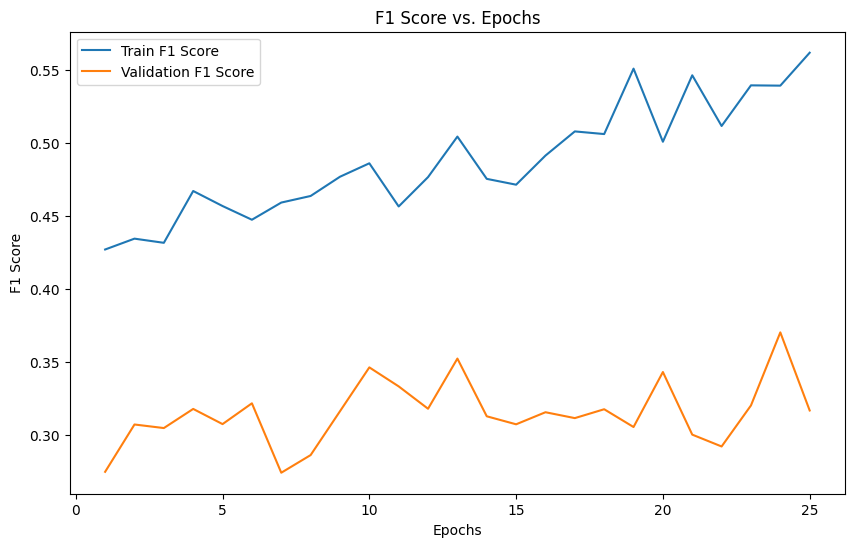

In [ ]:
# Defining the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 25
train_f1_scores = []
val_f1_scores = []

for epoch in range(num_epochs):
    model.train()
    train_preds = []
    train_true = []

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        train_preds.extend(predicted.cpu().numpy())
        train_true.extend(labels.cpu().numpy())

    train_f1 = f1_score(train_true, train_preds, average='weighted')
    train_f1_scores.append(train_f1)

    model.eval()
    val_preds = []
    val_true = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            val_preds.extend(predicted.cpu().numpy())
            val_true.extend(labels.cpu().numpy())

    val_f1 = f1_score(val_true, val_preds, average='weighted')
    val_f1_scores.append(val_f1)

# Plotting F1 score vs. Epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_f1_scores, label='Train F1 Score')
plt.plot(range(1, num_epochs + 1), val_f1_scores, label='Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Epochs')
plt.legend()
plt.show()

### Number of Trainable Parameters

In [ ]:
model = CustomCNN(num_classes=8)

# Calculating the total trainable parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")

Total trainable parameters: 171720
